In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge,Lasso, ElasticNet
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import KFold


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")


/home/demetra/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [3]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [4]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [5]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


**RIDGE**

0.25 ripartition
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 99
Tr

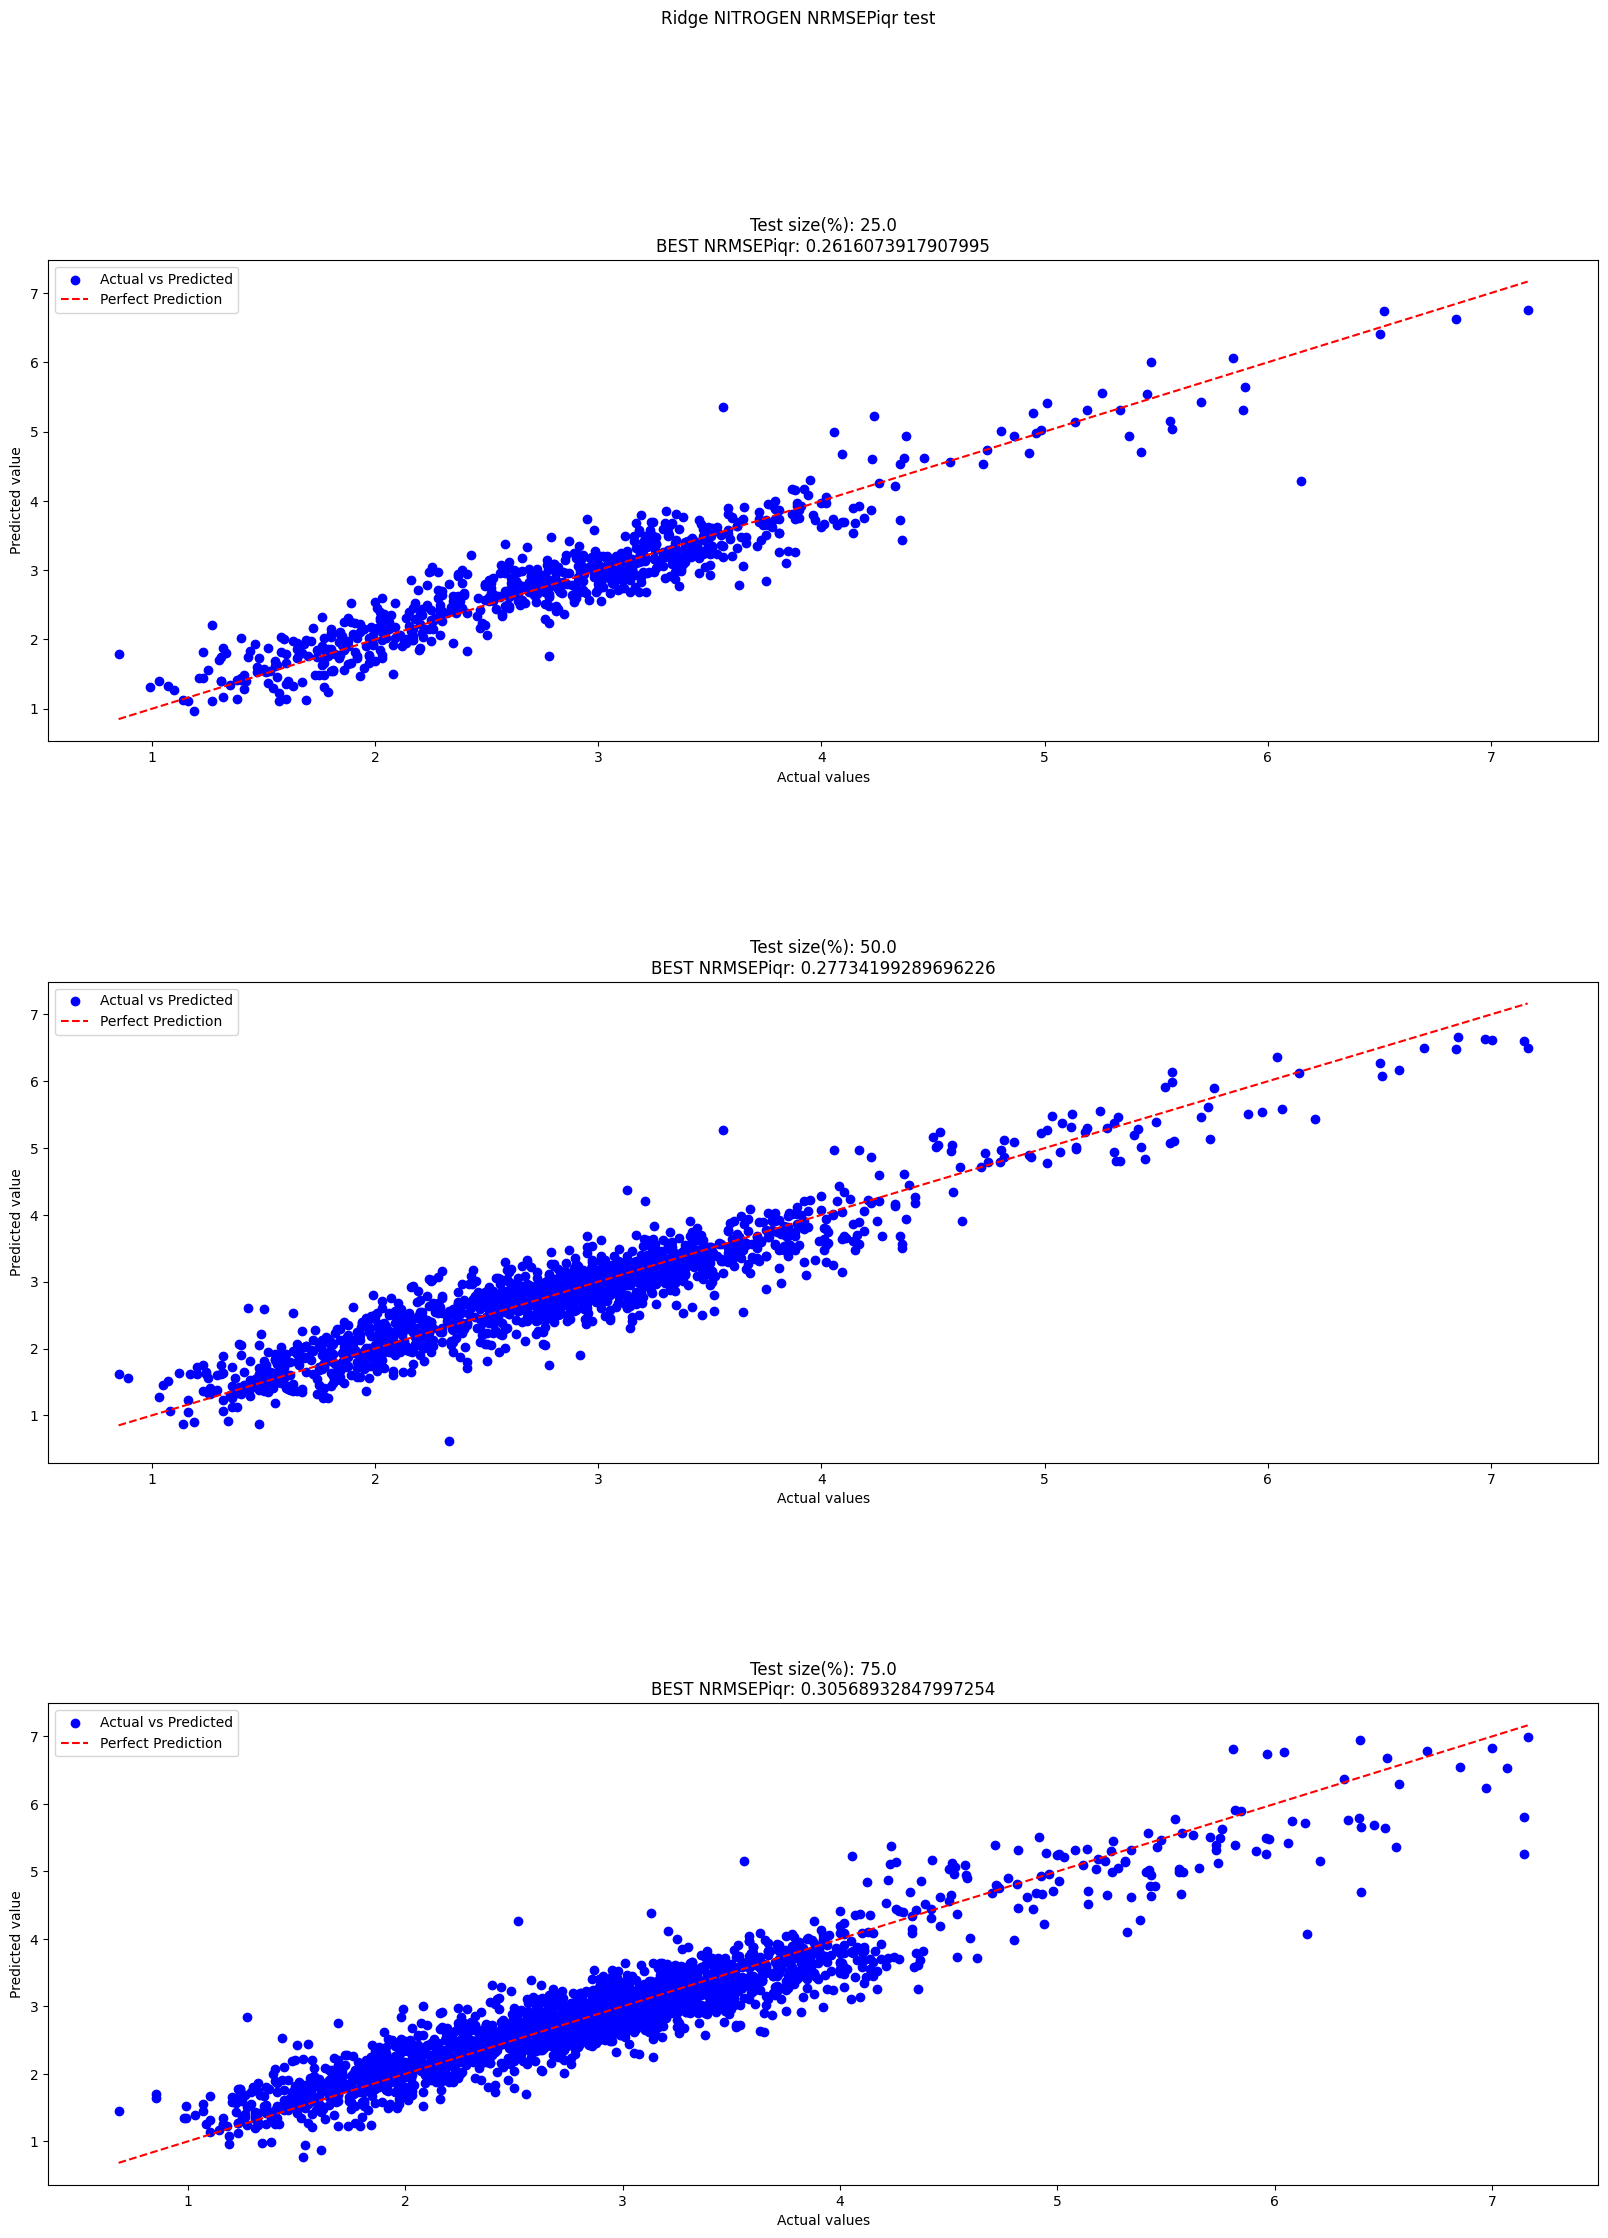

In [11]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
            ridge_reg_pipeline = make_pipeline(StandardScaler(),Ridge())
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_pipeline,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
            
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.best_estimator_.predict(X_test)
    
            #save NRMSEP of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["ridge__alpha"])
              best_data_1["seed"] = seeds[i]
              best_data_1["model"] = evolved_estimator.best_estimator_
              best_data_1["time"] = elapsed_time


        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))



In [7]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials, size=trials)

ripartitions = [0.25,0.5,0.75]

results = []  


for ripartition in ripartitions:

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            result = {"Ripartition":None,
                       "Trial":None,
                         "alpha_bayesian":None,
                           "alpha_evolutionary":None,
                             "bayesian_time":None,
                             "evolutionary_time" :None,
                             "NRMSEPiqr_bayesian":None,
                              "NRMSEPiqr_evolutionary":None,
                              "seed": None}
            

            print("Trial:",i+1)
                
            result["Ripartition"] = ripartition
            result["Trial"] = i +1
            result["seed"] = seeds[i]
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
            #sturges = int(1 + np.log(len(X_train)))    
            ridge_reg_pipeline = make_pipeline(StandardScaler(),Ridge())

            kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_pipeline,
                                  cv=kf,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
            
            bayesian_estimator = BayesSearchCV(
                                ridge_reg_pipeline,
                                {'ridge__alpha': (1/100000,0.01,'log-uniform')},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
            
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["evolutionary_time"] = elapsed_time
            result["alpha_evolutionary"] = float(evolved_estimator.best_params_["ridge__alpha"])
       
            start_time = time.time()
            bayesian_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["bayesian_time"] = elapsed_time
            result["alpha_bayesian"] = float(bayesian_estimator.best_params_["ridge__alpha"])
    
           
            result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

            result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
            print(result)
            results.append(result)




0.25 ripartition
Trial: 1
{'Ripartition': 0.25, 'Trial': 1, 'alpha_bayesian': 5.3899145244486326e-05, 'alpha_evolutionary': 0.003283429056212107, 'bayesian_time': 3.0411341190338135, 'evolutionary_time': 31.796574354171753, 'NRMSEPiqr_bayesian': 0.34203766739250696, 'NRMSEPiqr_evolutionary': 0.339959444926916}
Trial: 2
{'Ripartition': 0.25, 'Trial': 2, 'alpha_bayesian': 0.0008259067853637235, 'alpha_evolutionary': 0.002104028780622016, 'bayesian_time': 2.970257043838501, 'evolutionary_time': 33.575103998184204, 'NRMSEPiqr_bayesian': 0.29273061580690235, 'NRMSEPiqr_evolutionary': 0.29268943682120613}
Trial: 3
{'Ripartition': 0.25, 'Trial': 3, 'alpha_bayesian': 0.000976333699003223, 'alpha_evolutionary': 0.0006696080601674463, 'bayesian_time': 2.7751266956329346, 'evolutionary_time': 31.542063236236572, 'NRMSEPiqr_bayesian': 0.31172280306960676, 'NRMSEPiqr_evolutionary': 0.3118723071335853}
Trial: 4
{'Ripartition': 0.25, 'Trial': 4, 'alpha_bayesian': 0.0014942110369460945, 'alpha_evoluti

In [11]:
df = pd.DataFrame(results)
df.to_excel("Bayes_vs_Evol.xlsx")

**LASSO**

0.25 ripartition
Trial:  1
Trial:  2
Trial:  3
Trial:  4
Trial:  5
Trial:  6
Trial:  7
Trial:  8
Trial:  9
Trial:  10
Trial:  11
Trial:  12
Trial:  13
Trial:  14
Trial:  15
Trial:  16
Trial:  17
Trial:  18
Trial:  19
Trial:  20
Trial:  21
Trial:  22
Trial:  23
Trial:  24
Trial:  25
Trial:  26
Trial:  27
Trial:  28
Trial:  29
Trial:  30
Trial:  31
Trial:  32
Trial:  33
Trial:  34
Trial:  35
Trial:  36
Trial:  37
Trial:  38
Trial:  39
Trial:  40
Trial:  41
Trial:  42
Trial:  43
Trial:  44
Trial:  45
Trial:  46
Trial:  47
Trial:  48
Trial:  49
Trial:  50
Trial:  51
Trial:  52
Trial:  53
Trial:  54
Trial:  55
Trial:  56
Trial:  57
Trial:  58
Trial:  59
Trial:  60
Trial:  61
Trial:  62
Trial:  63
Trial:  64
Trial:  65
Trial:  66
Trial:  67
Trial:  68
Trial:  69
Trial:  70
Trial:  71
Trial:  72
Trial:  73
Trial:  74
Trial:  75
Trial:  76
Trial:  77
Trial:  78
Trial:  79
Trial:  80
Trial:  81
Trial:  82
Trial:  83
Trial:  84
Trial:  85
Trial:  86
Trial:  87
Trial:  88
Trial:  89
Trial:  90
Tr

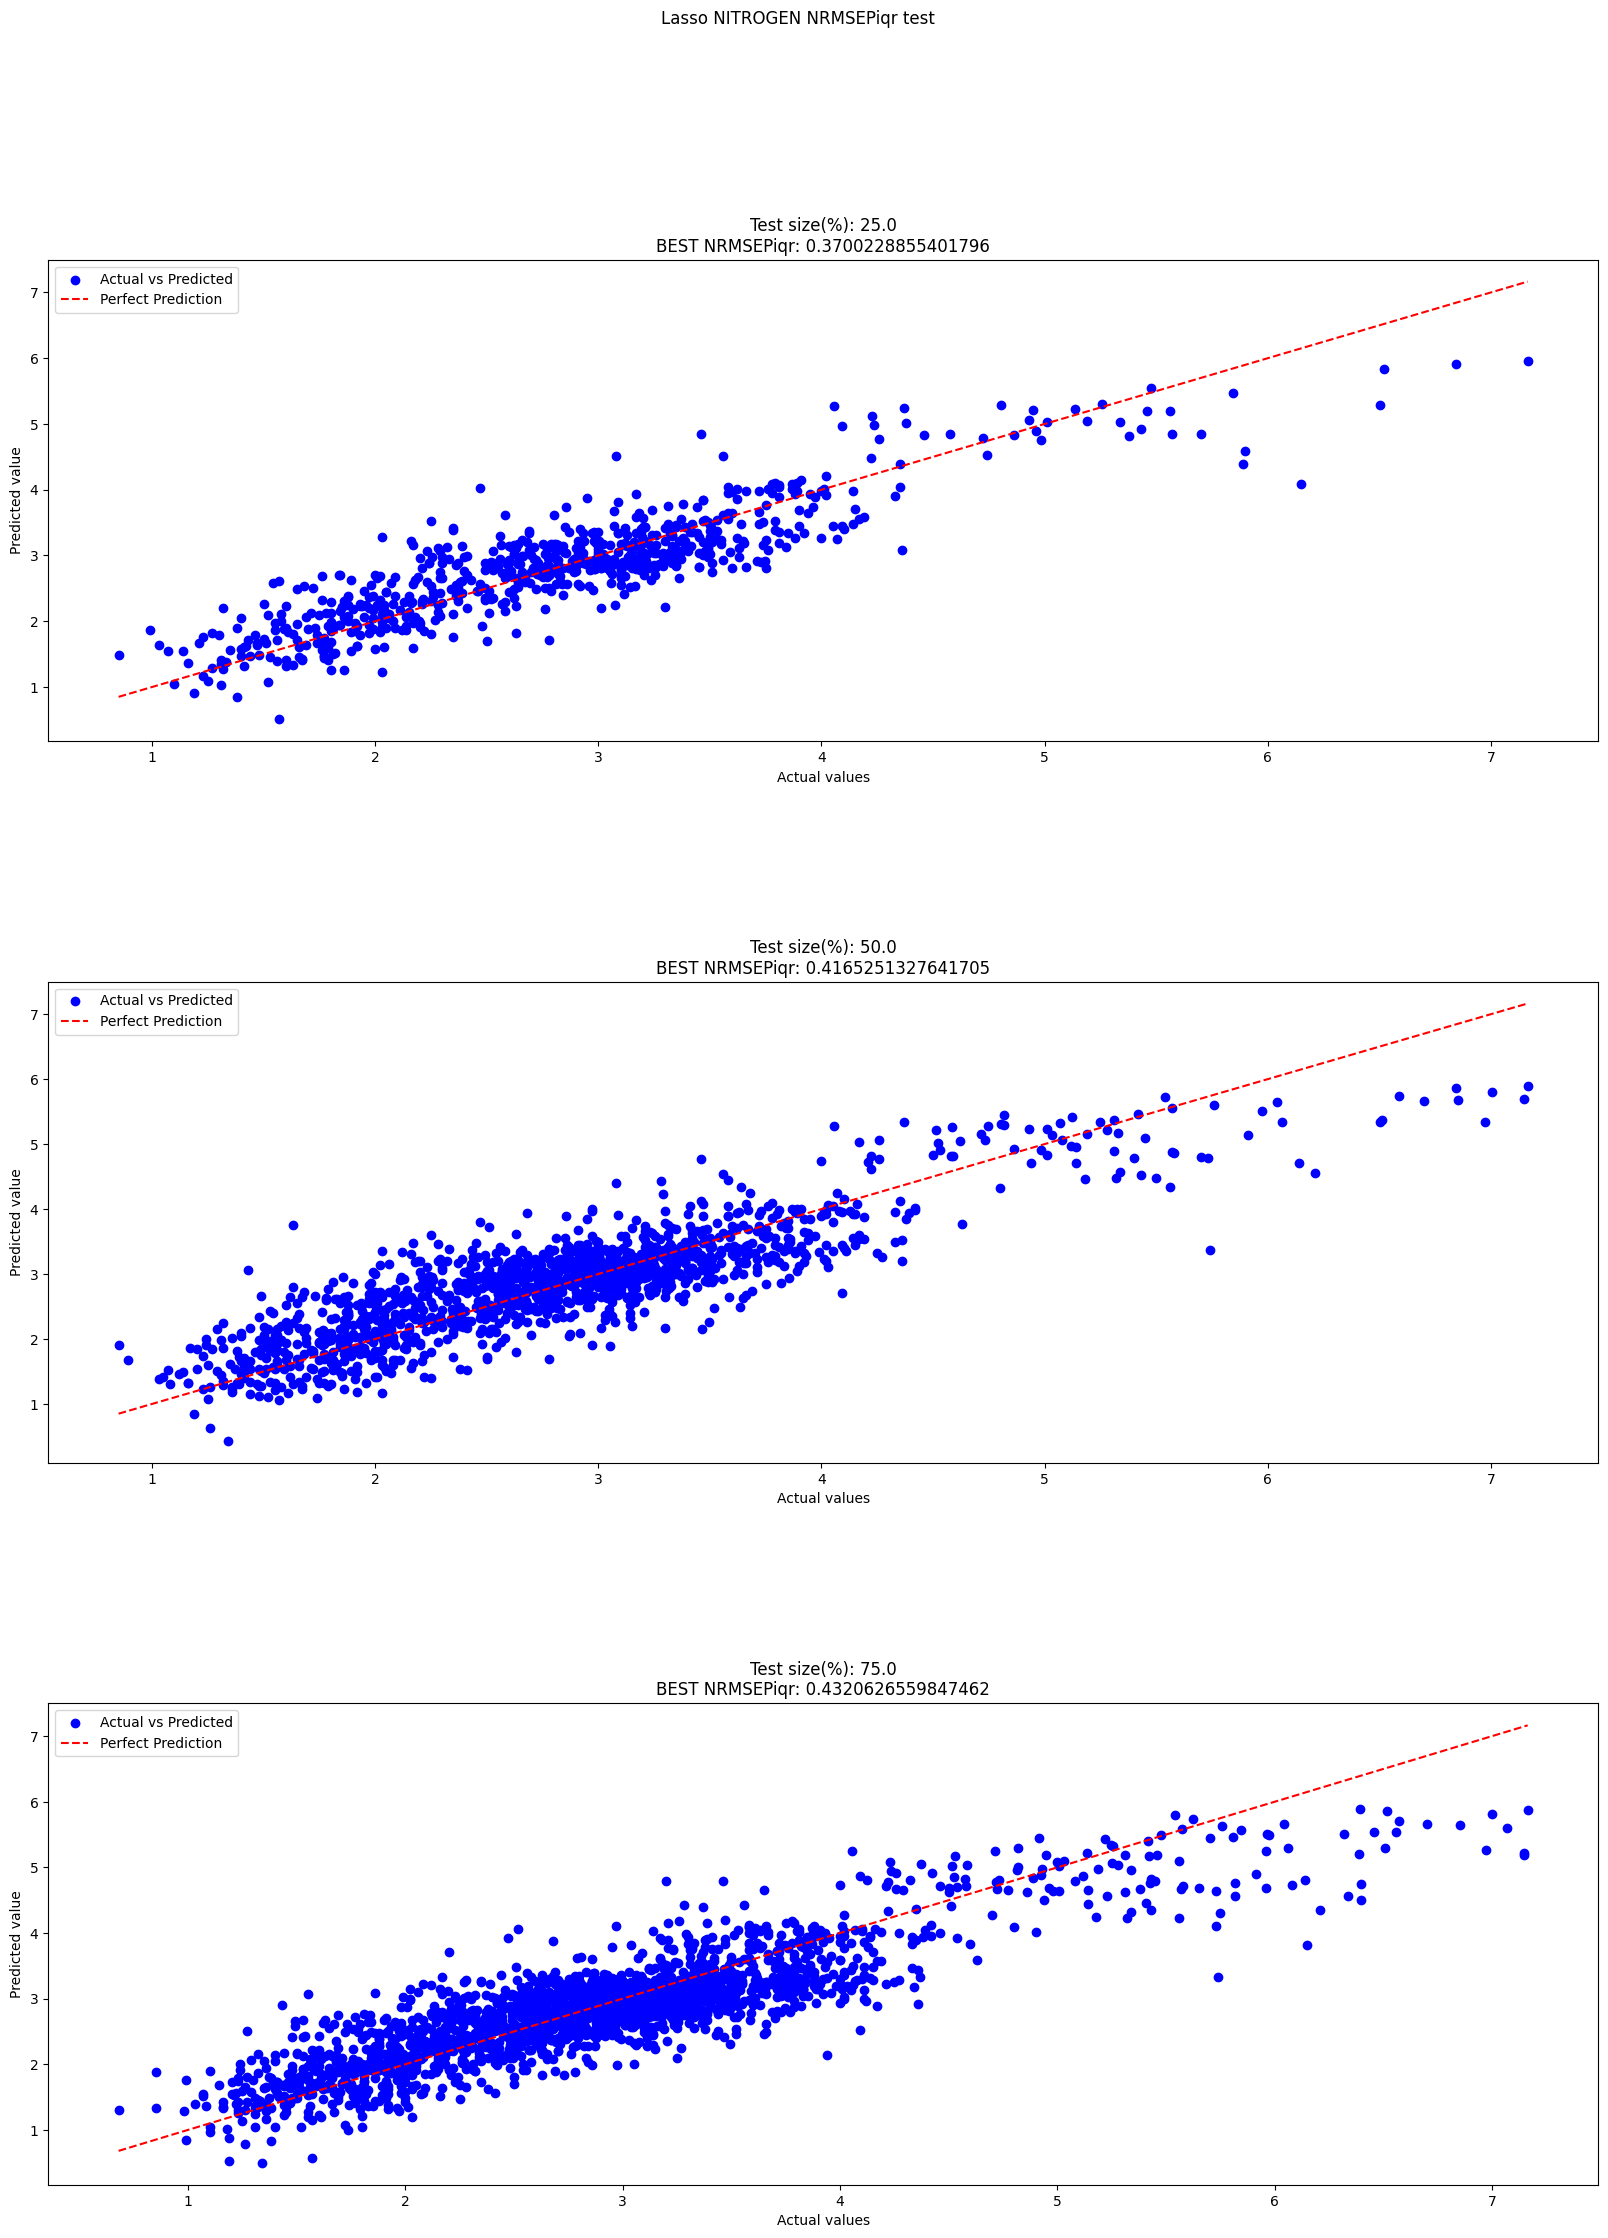

In [12]:




if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0




'''NITROGEN'''

for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}



        run_name = str(ripartition) + " ripartition"
        print(run_name)

        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'lasso__alpha': Continuous(1/100000,0.01)}
            lasso_pipeline = make_pipeline(StandardScaler(),Lasso())
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_pipeline,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.best_estimator_.predict(X_test)
    
            
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_cd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["lasso__alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time



        results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))




**ELASTIC NET**

0.25 ripartition
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 99
Tr

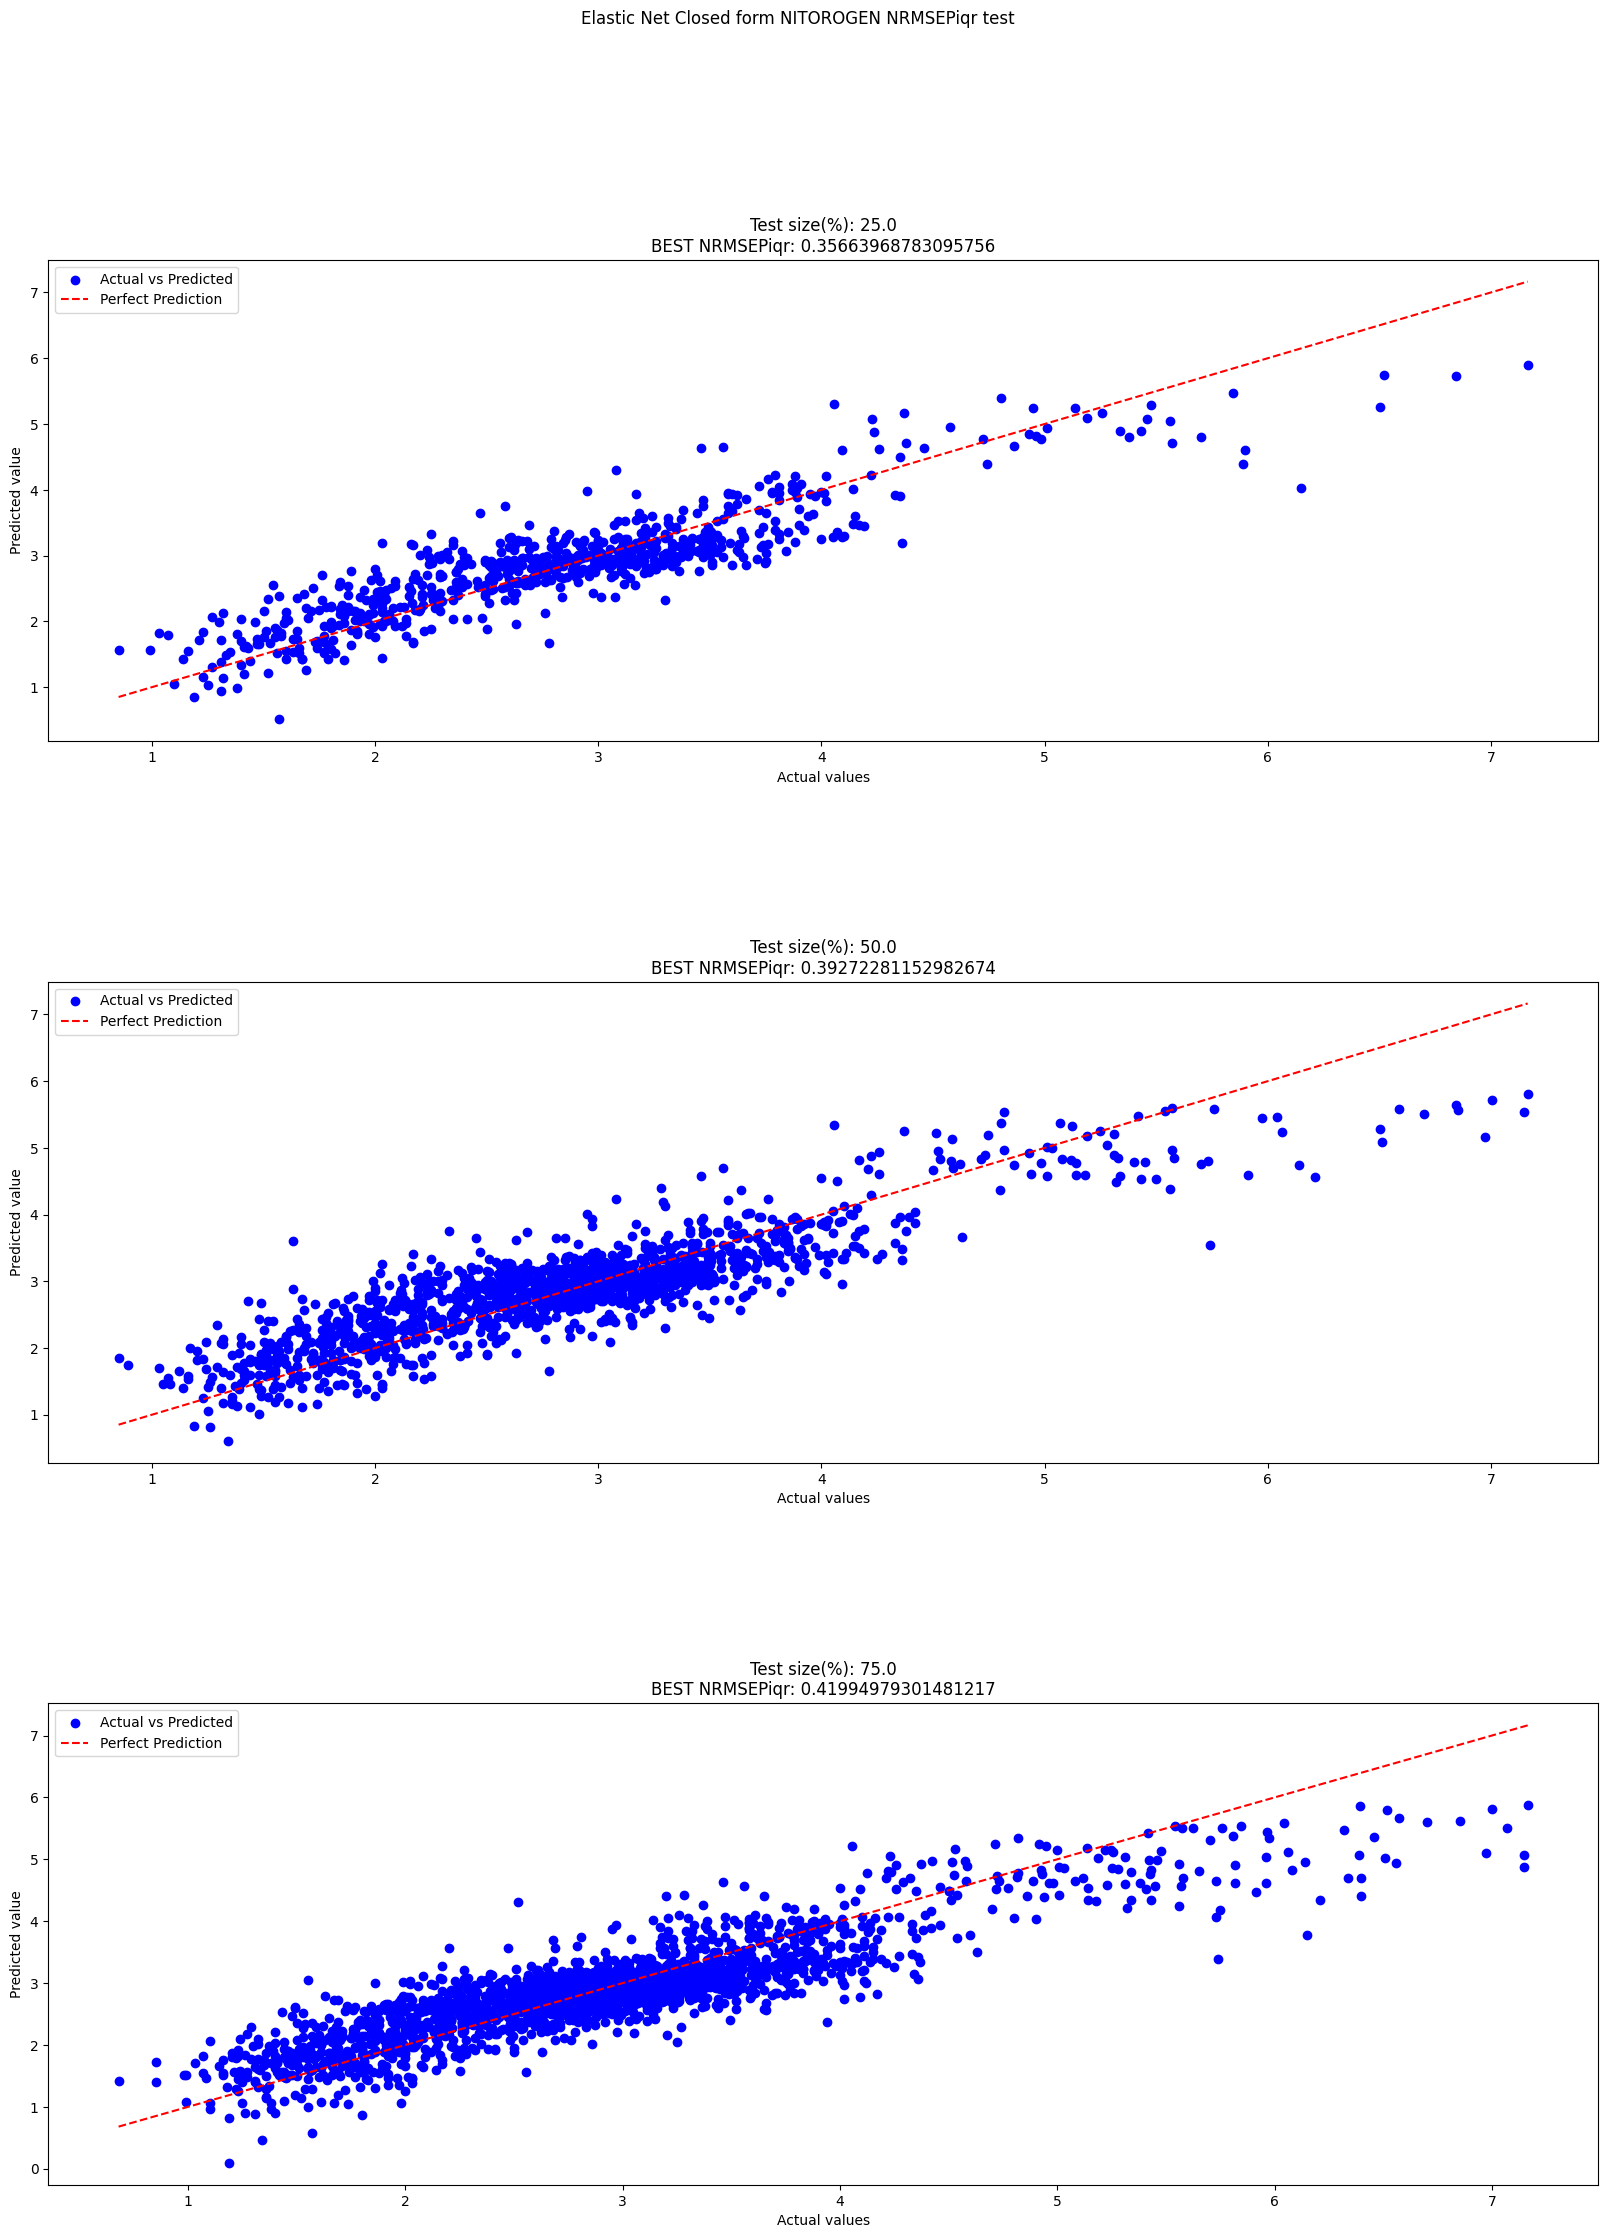

In [13]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Elastic Net Closed form NITOROGEN NRMSEPiqr test' + "\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

  
        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test": None, "Y_pred": None, "seed": None,"alpha":None,"r":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
 
        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'elasticnet__alpha': Continuous(1/100000,0.01),"elasticnet__l1_ratio":Continuous(0,1)}
            elastic_pipeline = make_pipeline(StandardScaler(),ElasticNet())
            
            evolved_estimator = GASearchCV(estimator=elastic_pipeline,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_elastic_cd =  evolved_estimator.best_estimator_.predict(X_test)
    
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_elastic_cd))
    
        
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_elastic_cd
              best_data_1["alpha"] = float(evolved_estimator.best_params_["elasticnet__alpha"])
              best_data_1["r"] = float(evolved_estimator.best_params_["elasticnet__l1_ratio"])
              best_data_1["seed"] = seeds[i]
              best_data_1["model"] = evolved_estimator.best_estimator_
              best_data_1["time"] = elapsed_time

    
    
       
        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),str(best_data_1["seed"]), str(best_data_1["r"]),best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","r", "Time(sec)"]
print(tabulate(results, headers,  tablefmt="double_outline"))


**RIDGE REGRESSION with SGD NRMSEPiqr**

In [ ]:


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = [] 

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge regression SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:



        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
  
        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            X_train= std_scaler.fit_transform(X_train)
            X_test= std_scaler.transform(X_test)
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_ridge_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time

        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))




**LASSO with SGD NITROGEN**

In [ ]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0


for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        

        run_name = str(ripartition) + " ripartition"
        print(run_name)

        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l1", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=lasso_reg_sgd,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time)/60 #elapsed time in minute
    
            # Make predictions using the testing set
            Y_pred_lasso_sgd =  evolved_estimator.predict(X_test)
    
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time

        
        results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time (min)"]

print(tabulate(results, headers,  tablefmt="double_outline"))



0.25 ripartition
Trial:  1
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.789432	0.0585422  	-0.693824  	-0.881485  
1  	20    	-0.847781	0.0381339  	-0.781961  	-0.881485  
2  	20    	-0.869646	0.0263883  	-0.792099  	-0.881485  
3  	20    	-0.866906	0.030338   	-0.789538  	-0.882163  
4  	20    	-0.87419 	0.0218142  	-0.808824  	-0.882163  
5  	20    	-0.874634	0.0219375  	-0.808824  	-0.882163  
6  	20    	-0.862229	0.0238511  	-0.827719  	-0.882163  
7  	20    	-0.854468	0.0269255  	-0.807738  	-0.882163  
8  	20    	-0.877744	0.00722557 	-0.856404  	-0.88226   
9  	20    	-0.880496	0.00151011 	-0.87752   	-0.88226   
10 	20    	-0.86811 	0.0201937  	-0.827521  	-0.88226   
Trial:  2
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.811924	0.0596792  	-0.696237  	-0.881136  
1  	20    	-0.861092	0.029802   	-0.796931  	-0.883445  
2  	20    	-0.876492	0.00951156 	-0.851578  	-0.883832  
3  	20    	-0.854409	0.055553   	-0.700881  	-0.883

**ELASTIC NET with SGD NRMSEPiqr**

In [ ]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Elastic Net SGD NITOROGEN NRMSEPiqr test' + "\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:


        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test": None, "Y_pred": None, "seed": None,"alpha":None,"r":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)

        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01),"l1_ratio":Continuous(0,1)}
            elastic_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="elasticnet", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=elastic_reg_sgd,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time)/60 #elapsed time in minute
    
            # Make predictions using the testing set
            Y_pred_elastic_sgd =  evolved_estimator.predict(X_test)
    
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_elastic_sgd))
    
        
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_elastic_sgd
              best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
              best_data_1["r"] = float(evolved_estimator.best_params_["l1_ratio"])
              best_data_1["seed"] = seeds[i]
              best_data_1["model"] = evolved_estimator.best_estimator_
              best_data_1["time"] = elapsed_time

    
       
        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),str(best_data_1["seed"]), str(best_data_1["r"]),best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","r","Time (min)"]
print(tabulate(results, headers,  tablefmt="double_outline"))
